In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from hopfield import HopfieldNetwork
from pattern_generate import PatternGenerator

In [5]:
def hopfield_recall(ERR = 0.8,
                    img_size = 16,
                    NEURONS = 256,
                    pattern_numbers = 30,
                    death_rate = 0,
                    residual_strength = 0,
                    plaque_intensity = 0,
                    plaque_rate = 0.05,
                    noise_level = 0.25):
    
    def load_patterns(folder="saved_patterns", n=100):
        with open(os.path.join(folder, "metadata.json"), "r") as f:
            metadata = json.load(f)

        selected = list(metadata.items())[:n]
        patterns = {}
        for filename, info in selected:
            pattern = np.load(os.path.join(folder, filename))
            key_name = f"自動圖形 {filename.split('.')[0][-3:]}"
            patterns[key_name] = pattern
        return patterns
    
    pattern_options = {}

    generator = PatternGenerator(size=img_size)

    # Example: Use "十字" pattern as reference
    cross_pattern = np.array([1 if (i % img_size == img_size//2 or i // img_size == img_size//2) else -1 for i in range(img_size*img_size)])
    #test = np.array([1 if i//16 == i%16 else -1 for i in range(256)])
    #print(generator.normalized_complexity(test))

    similar_patterns = generator.generate_similar_complexity_patterns(cross_pattern, count=pattern_numbers, tolerance=ERR)

    generator.save_patterns(similar_patterns)
    #generator.show_patterns(similar_patterns, n=pattern_numbers, save_path="saved_patterns/overview.png")

    patterns = load_patterns(n=pattern_numbers)
    pattern_options.update(patterns)  # 將自動生成的圖形加進選單

    pattern_list = []

    for i in pattern_options:
        pattern_list.append(pattern_options[i])

    hop = HopfieldNetwork(N=NEURONS, death_rate=death_rate, residual_strength=residual_strength, plaque_intensity=plaque_intensity, 
                        plaque_rate=plaque_rate)
    hop.train(pattern_list)

    success_rate = []

    for i in pattern_options:
        input_pattern = pattern_options[i]
        noisy_input = hop.add_noise(input_pattern, noise_level=noise_level)
        recalled = hop.recall(noisy_input)

        while len(input_pattern) < len(recalled):
            n = int((len(input_pattern))**(0.5))
            input_pattern = np.reshape(input_pattern, (n, n))
            newer_p = np.reshape([0 for _ in range(4*n*n)], (2*n, 2*n))
            for i in range(n):
                for j in range(n):
                    newer_p[2*i][2*j] = input_pattern[i][j]
                    newer_p[2*i+1][2*j] = input_pattern[i][j]
                    newer_p[2*i][2*j+1] = input_pattern[i][j]
                    newer_p[2*i+1][2*j+1] = input_pattern[i][j]
            input_pattern = []
            for i in newer_p:
                input_pattern += list(i)
        success_rate.append(np.mean(recalled == input_pattern))
    #print("回憶成功率", success_rate)
    #print("平均回憶成功率", sum(success_rate)/len(success_rate))
    return sum(success_rate)/len(success_rate)

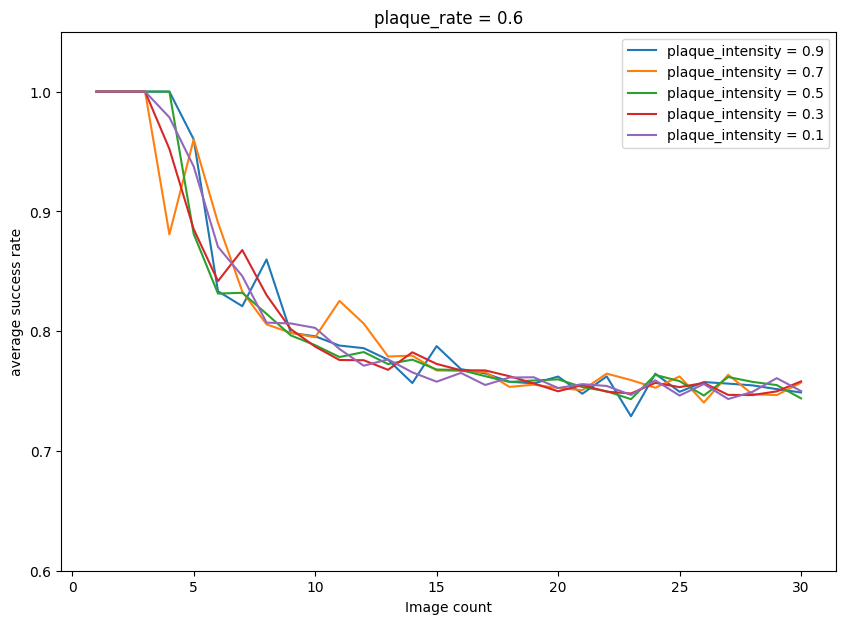

In [ ]:
N = 30
x = np.linspace(1, N, N)
dec = [0.9, 0.7, 0.5, 0.3, 0.1] 
z = [[] for _ in range(5)]
for i in range(1, N+1):
    for j in range(5):
        t = hopfield_recall(ERR = 0.2,
                            img_size = 16,
                            NEURONS = 256,
                            pattern_numbers = i,
                            death_rate = 0,
                            residual_strength = 0,
                            plaque_intensity = dec[j],
                            plaque_rate = 0.3,
                            noise_level = 0.25)
        z[j].append(t)
fig, ax = plt.subplots(figsize=(10, 7))
for i in range(5):
    ax.plot(x, z[i], label = "plaque_intensity = "+str(dec[i]))
ax.set_xlabel("Image count")
ax.set_ylabel("average success rate")
ax.set_title("plaque_rate = 0.6")
ax.set_ylim([0.6, 1.05])
plt.legend()
plt.show()